In [2]:
!pip install wget -q

In [3]:
import torch 
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST 
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
import urllib.request
import wget
import numpy as np
import tarfile
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os
import torchvision.transforms.functional as TF
torch.manual_seed(0)
%matplotlib inline

In [4]:
link = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz'

In [6]:
wget.download(link)

'imagenette2-160.tgz'

In [7]:
tf = tarfile.open('imagenette2-160.tgz')
tf.extractall('./data')

In [8]:
transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

dataset = torchvision.datasets.ImageFolder(root='./data/imagenette2-160/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [10]:
def show_image(image_tensor, num_images=20, size=(3, 28, 28), nrow=5):
    plt.rcParams["figure.figsize"] = (8,8)
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

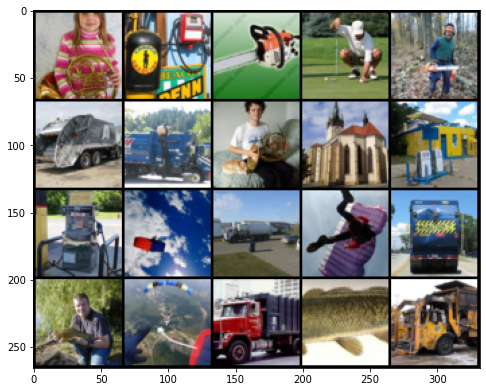

In [11]:
dataiter = iter(dataloader)
images, labels = dataiter.next()
show_image(images)

In [ ]:
images.shape

torch.Size([64, 3, 64, 64])

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [18]:
noise_dim = 64
im_dim= 3*64*64
lr= 0.0002
nz = 100
ngf = 64
ndf = 64
nc = 3
beta1 = 0.5

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
# Loss Function
criterion = nn.BCEWithLogitsLoss()
# Generator
gen = Generator()
gen.apply(weights_init)
print(gen)
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
# Discriminator 
disc = Discriminator()
disc.apply(weights_init)
print(disc)
disc_optim = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Step 100: gen_loss: 69.96793800592422, disc_loss: 52.235069274902344


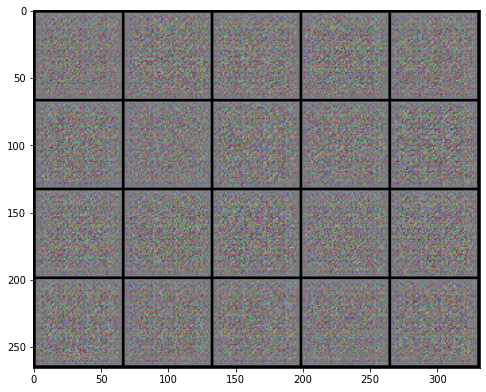

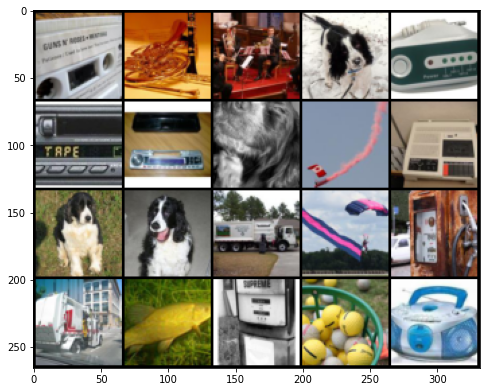

Step 200: gen_loss: 69.31368446350098, disc_loss: 50.598756432533264


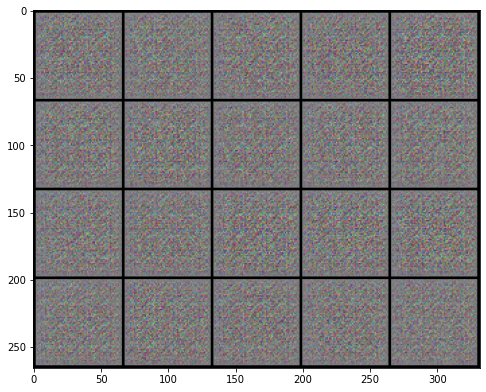

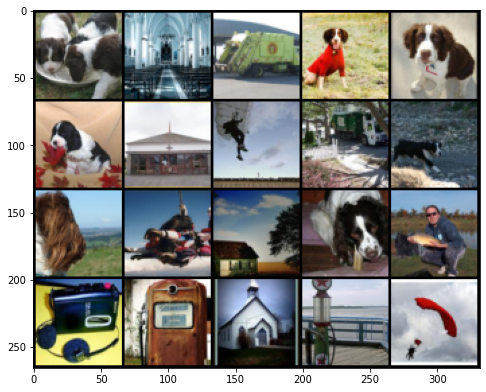

KeyboardInterrupt: ignored

In [22]:
epochs = 5 
step = 0
noise_dim = 64
display_step = 100 
mean_gen_loss = 0
mean_disc_loss = 0
gen_loss = False
error = False

gen_losses = []
disc_losses = []

for epoch in range(epochs):
  for real, _ in dataloader: 
    batch_size = len(real)

    disc_optim.zero_grad()
    noise = torch.randn(batch_size, nz, 1, 1)
    fake = gen(noise)
    fake_pred = disc(fake.detach())
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
    real_pred = disc(real)
    real_loss = criterion(real_pred, torch.ones_like(real_pred))
    disc_loss = (fake_loss + real_loss) / 2
    mean_disc_loss += disc_loss.item()
    disc_loss.backward(retain_graph=True)
    disc_optim.step()

    gen_optim.zero_grad()
    noise_2 = torch.randn(batch_size, nz, 1, 1)
    fake_2 = gen(noise_2)
    fake_pred2 = disc(fake_2)
    # print(f"Step {step}: gen_loss: {mean_gen_loss}, disc_loss: {mean_disc_loss}")
    gen_loss = criterion(fake_pred2, torch.ones_like(fake_pred2))
    gen_loss.backward()
    gen_optim.step()
    mean_gen_loss += gen_loss.item()
 

    if step % display_step == 0 and step > 0:
      print(f"Step {step}: gen_loss: {mean_gen_loss}, disc_loss: {mean_disc_loss}")
      show_image(fake)
      show_image(real)
      disc_losses += [mean_disc_loss]
      gen_losses += [mean_gen_loss]
      mean_gen_loss = 0
      mean_disc_loss = 0 
    step +=1

In [ ]:
step_bins = 20
num_examples = (len(gen_losses) // step_bins) * step_bins
plt.plot(
    range(num_examples // step_bins), 
    torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
    label="Generator Loss"
)
plt.plot(
    range(num_examples // step_bins), 
    torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
    label="Discriminator Loss"
)
plt.legend()
plt.show()

[0/5][0/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


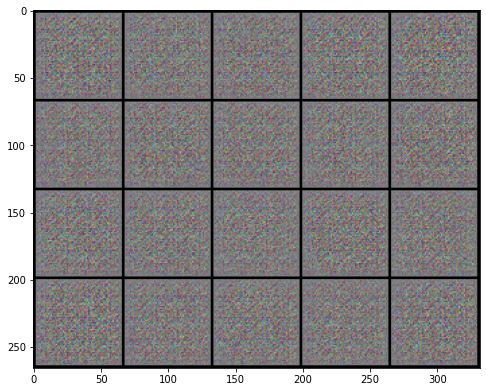

[0/5][50/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][100/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][0/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][50/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][100/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


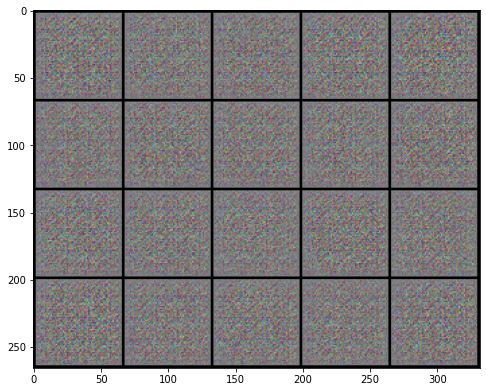

[2/5][0/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][50/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][100/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][0/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][50/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


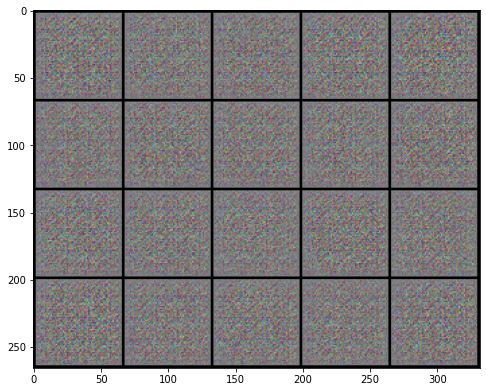

[3/5][100/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][0/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][50/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][100/148]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


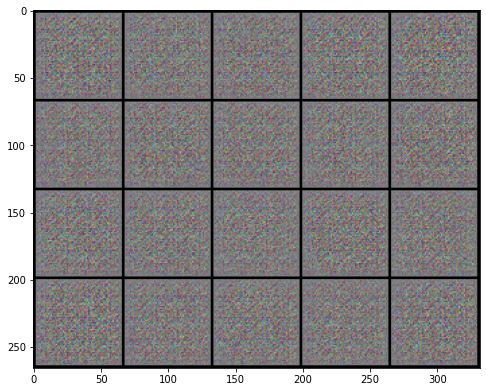

In [35]:
epochs = 5 
step = 0
noise_dim = 64
display_step = 100 
mean_gen_loss = 0
mean_disc_loss = 0
gen_loss = False
error = False

gen_losses = []
disc_losses = []

img_list = []
G_losses = []
D_losses = []
iters = 0

fixed_noise = torch.randn(64, nz, 1, 1)

for epoch in range(epochs):
  i = 0
  for real, _ in dataloader: 
    disc_optim.zero_grad()
    batch_size = len(real)
    real_pred = disc(real).view(-1)
    real_loss = criterion(real_pred, torch.ones_like(real_pred))
    real_loss.backward()
    D_x = real_pred.mean().item()

    noise = torch.randn(batch_size, nz, 1, 1)
    fake = gen(noise)
    fake_pred = disc(fake.detach()).view(-1)
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
    fake_loss.backward()
    D_G_z1 = fake_pred.mean().item()
    loss_disc = real_loss + fake_loss
    disc_optim.step()

    gen_optim.zero_grad()
    fake_pred = disc(fake.detach()).view(-1)
    loss_gen = criterion(fake_pred, torch.zeros_like(fake_pred))
    loss_gen.backward()
    D_G_z2 = fake_pred.mean().item()
    gen_optim.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     loss_disc.item(), loss_gen.item(), D_x, D_G_z1, D_G_z2))

    G_losses.append(loss_gen.item())
    D_losses.append(loss_disc.item())

    i +=1

    if (iters % 250 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
      test_img = gen(fixed_noise).detach()
      show_image(test_img)
      img_list.append(make_grid(test_img, padding=2, normalize=True))

    iters += 1


In [36]:
from torchvision.models import inception_v3

In [38]:
inception_model = inception_v3(pretrained=False, init_weights=True)

In [39]:
url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
wget.download(url)

'inception_v3_google-1a9a5a14.pth'

In [40]:
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model
inception_model = inception_model.eval()

In [41]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [42]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [43]:
def show_image2(image_tensor, num_images=20, size=(3, 28, 28), nrow=5):
    plt.rcParams["figure.figsize"] = (8,8)
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [44]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [54]:
fake_features_list = []
real_features_list = []

from tqdm import tqdm
n_samples = 512 # The total number of samples
batch_size =  64 # Samples per iteration
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)
device = 'cpu'
cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
  for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
    # print(real_example.shape)
    real_samples = real_example
    # print(real_samples.shape)
    real_samples = preprocess(real_samples)
    # print(real_samples.shape)
    
    real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
    real_features_list.append(real_features)

    noise = noise = torch.randn(batch_size, nz, 1, 1)
    fake_images = gen(noise)
    print('fake:',fake_images.shape)
    # fake_images = fake_images.reshape(64,1,64 ,64)
    # print(fake_images.shape)
    fake_images = fake_images.view(batch_size, 3, 64, 64).expand(-1, 3,-1, -1)
    # print(fake_images.shape)
    fake_samples = preprocess(fake_images)
    # print(fake_samples.shape)
    fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
    fake_features_list.append(fake_features)
    cur_samples += len(real_samples)
    if cur_samples >= n_samples:
        break








  0%|          | 0/8 [00:00<?, ?it/s]

fake: torch.Size([64, 3, 64, 64])








 12%|█▎        | 1/8 [00:37<04:20, 37.19s/it]

fake: torch.Size([64, 3, 64, 64])








 25%|██▌       | 2/8 [01:14<03:42, 37.16s/it]

fake: torch.Size([64, 3, 64, 64])








 38%|███▊      | 3/8 [01:51<03:05, 37.13s/it]

fake: torch.Size([64, 3, 64, 64])








 50%|█████     | 4/8 [02:28<02:28, 37.14s/it]

fake: torch.Size([64, 3, 64, 64])








 62%|██████▎   | 5/8 [03:05<01:51, 37.14s/it]

fake: torch.Size([64, 3, 64, 64])








 75%|███████▌  | 6/8 [03:42<01:14, 37.14s/it]

fake: torch.Size([64, 3, 64, 64])








 88%|████████▊ | 7/8 [04:20<00:37, 37.24s/it]

fake: torch.Size([64, 3, 64, 64])


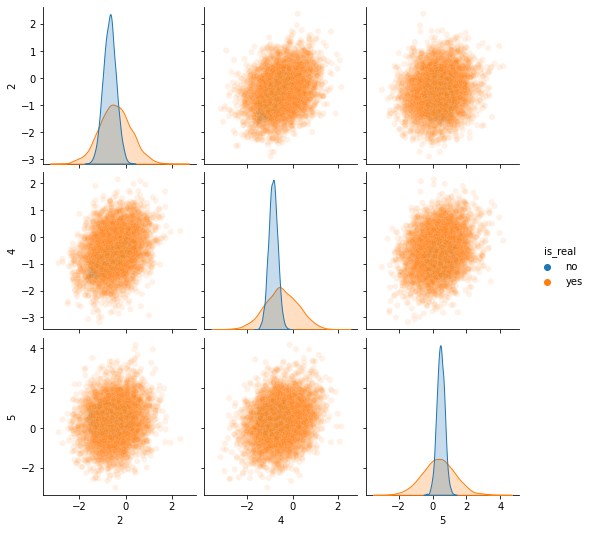

In [55]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

mu_fake = torch.mean(fake_features_all, axis = 0)
mu_real = torch.mean(real_features_all, axis = 0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

from torch.distributions import MultivariateNormal
import seaborn as sns
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd

df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')
plt.show()

In [56]:
import scipy
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    return torch.norm(mu_x - mu_y) + torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

826.69140625
